<a href="https://colab.research.google.com/github/UCREL/Session_5_Large_Language_Models/blob/main/LLM_Sentiment_Analysis_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using Large Language Models (LLMs)

## Initial Setup

In [ ]:
# Logging in to Hugging Face to access LLMs
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Installing libraries which are not available in the Colab environment
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.9 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import pandas as pd

from transformers import AutoTokenizer, pipeline
import torch

from pprint import pprint
from tqdm.auto import tqdm
from sklearn import metrics

import time

## From Theory to Code

### Chat Templates

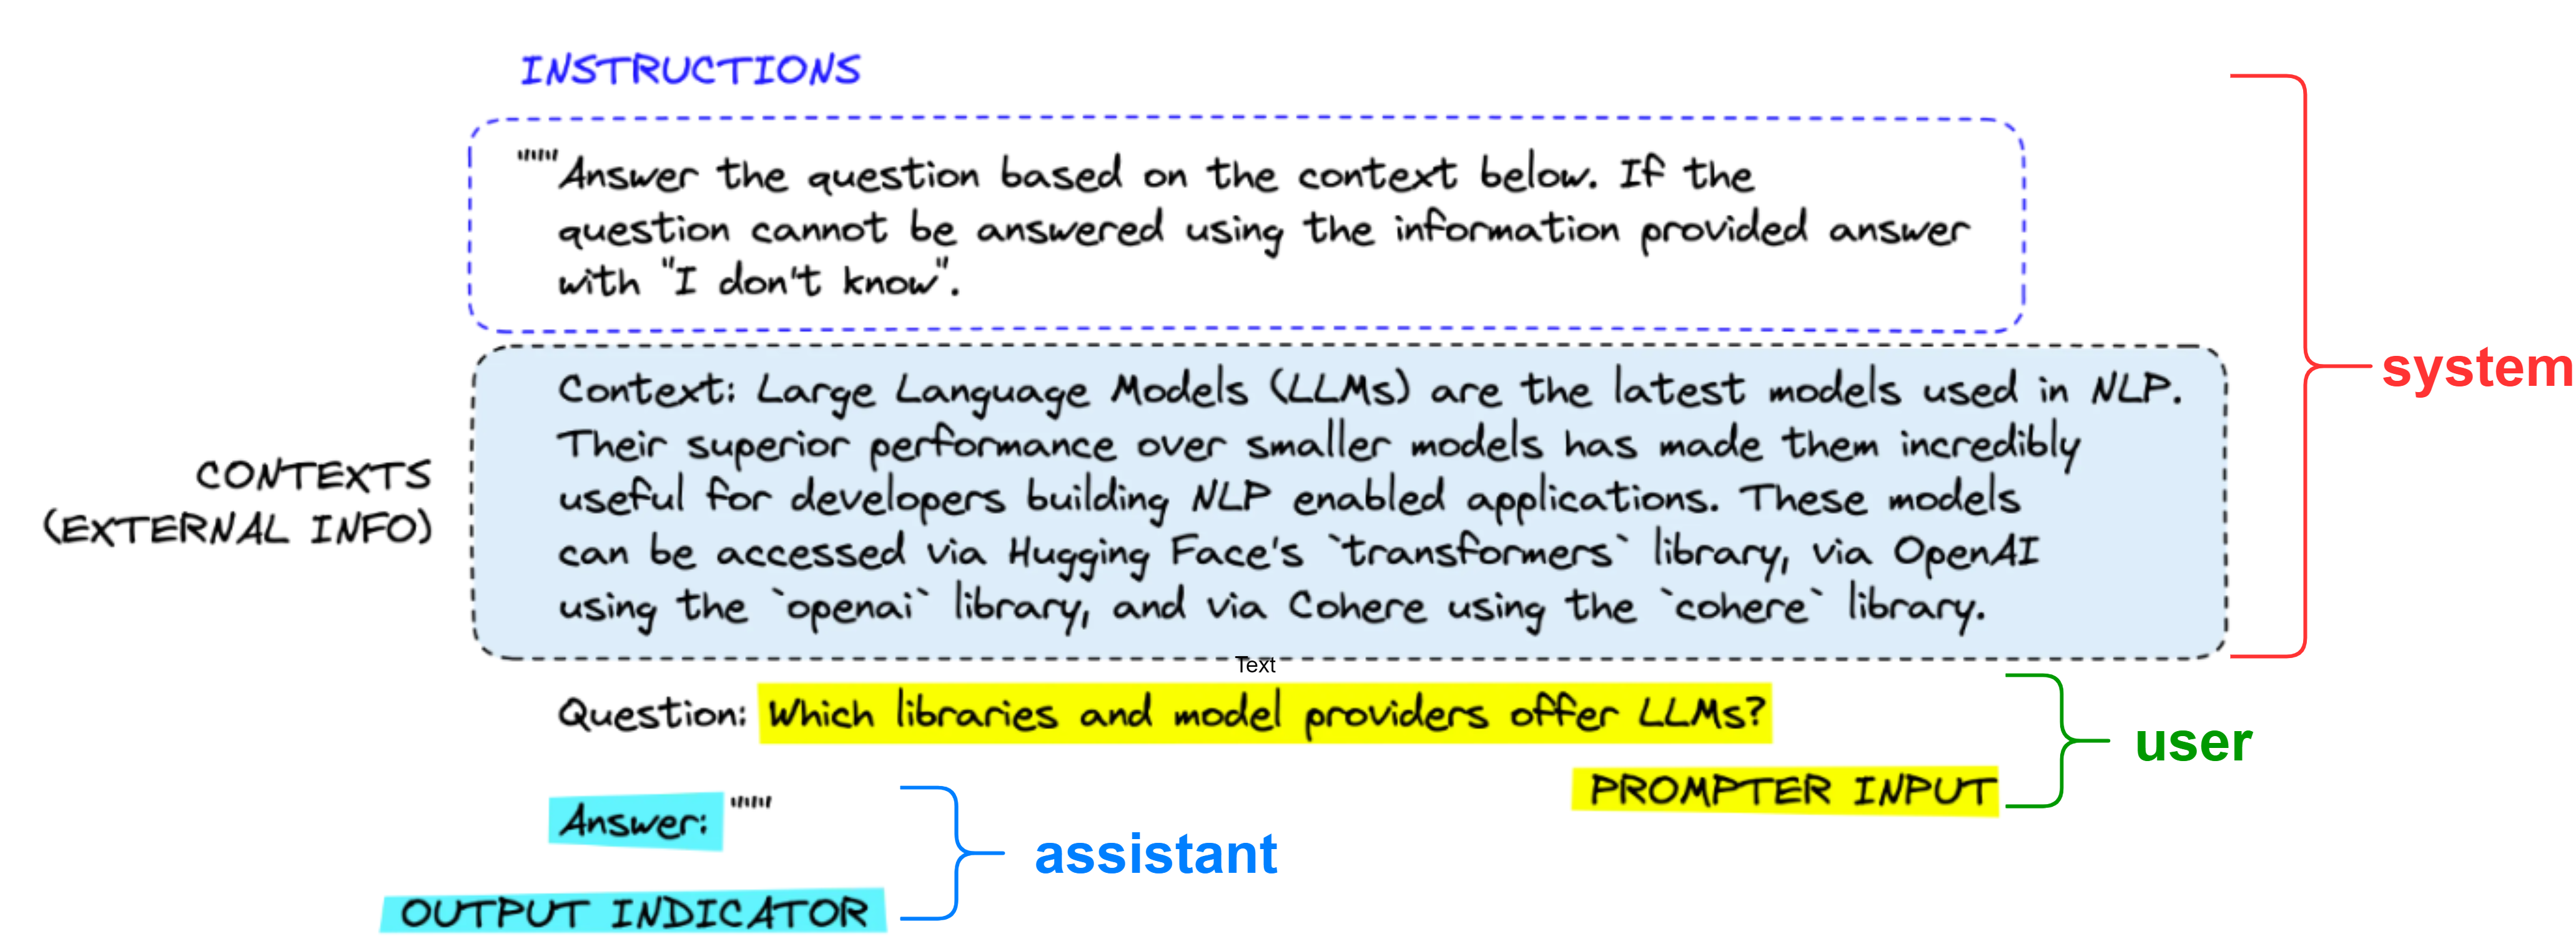

Similar to tokenisers, different models (especially, instruction-tuned/instruct models) expect different input formats for chat.

For example, the following is the prompt format of LLaMA3 Instruct model.

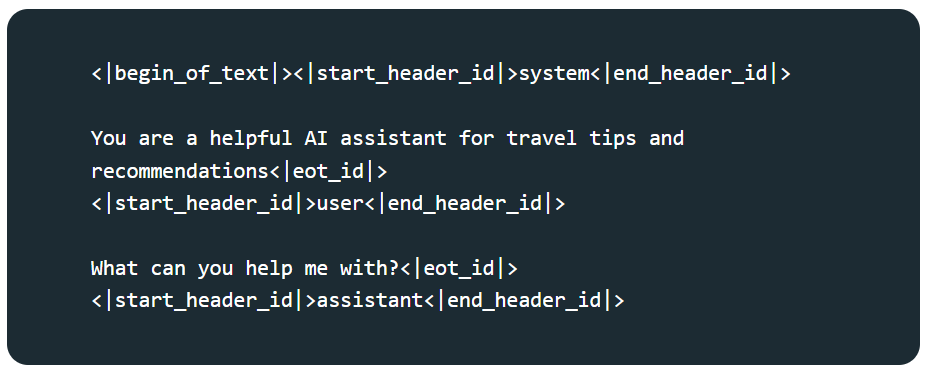<br>

The chat templates feature of the Transformers library can be used to easily convert inputs to the desired format as shown below.

Transformers' documentation: [Templates for Chat Models](https://huggingface.co/docs/transformers/v4.41.3/chat_templating)

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer_llama = AutoTokenizer.from_pretrained(model_id)

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

formatted_input=tokenizer_llama.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(formatted_input)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a pirate chatbot who always responds in pirate speak!<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




The chat template for a model is stored on the *tokenizer.chat_template* attribute. If no chat template is set, the default template for that model class is used instead.

Chat templates are written in [Jinja](https://jinja.palletsprojects.com/en/3.1.x/templates/), a templating language that allows you to write simple code that generates text. You can find more readily available samples [here](https://github.com/chujiezheng/chat_templates/tree/main/chat_templates).

Let's see how to add a custom chat template for the Mistral model. The default chat template of the Mistral Instruct model does not allow a system role, but we can add a custom template to include this role.

(Please upload the corresponding chat template to the Colab environment before running the following code.)

In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.3"

chat_template = open('/content/mistral-instruct.jinja').read()

tokenizer_mt = AutoTokenizer.from_pretrained(model_id)
tokenizer_mt.chat_template = chat_template

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

formatted_input=tokenizer_mt.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

tokenizer_config.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
print(formatted_input)


<s>You are a pirate chatbot who always responds in pirate speak!



        [INST] Who are you? [/INST]



### Text Generation

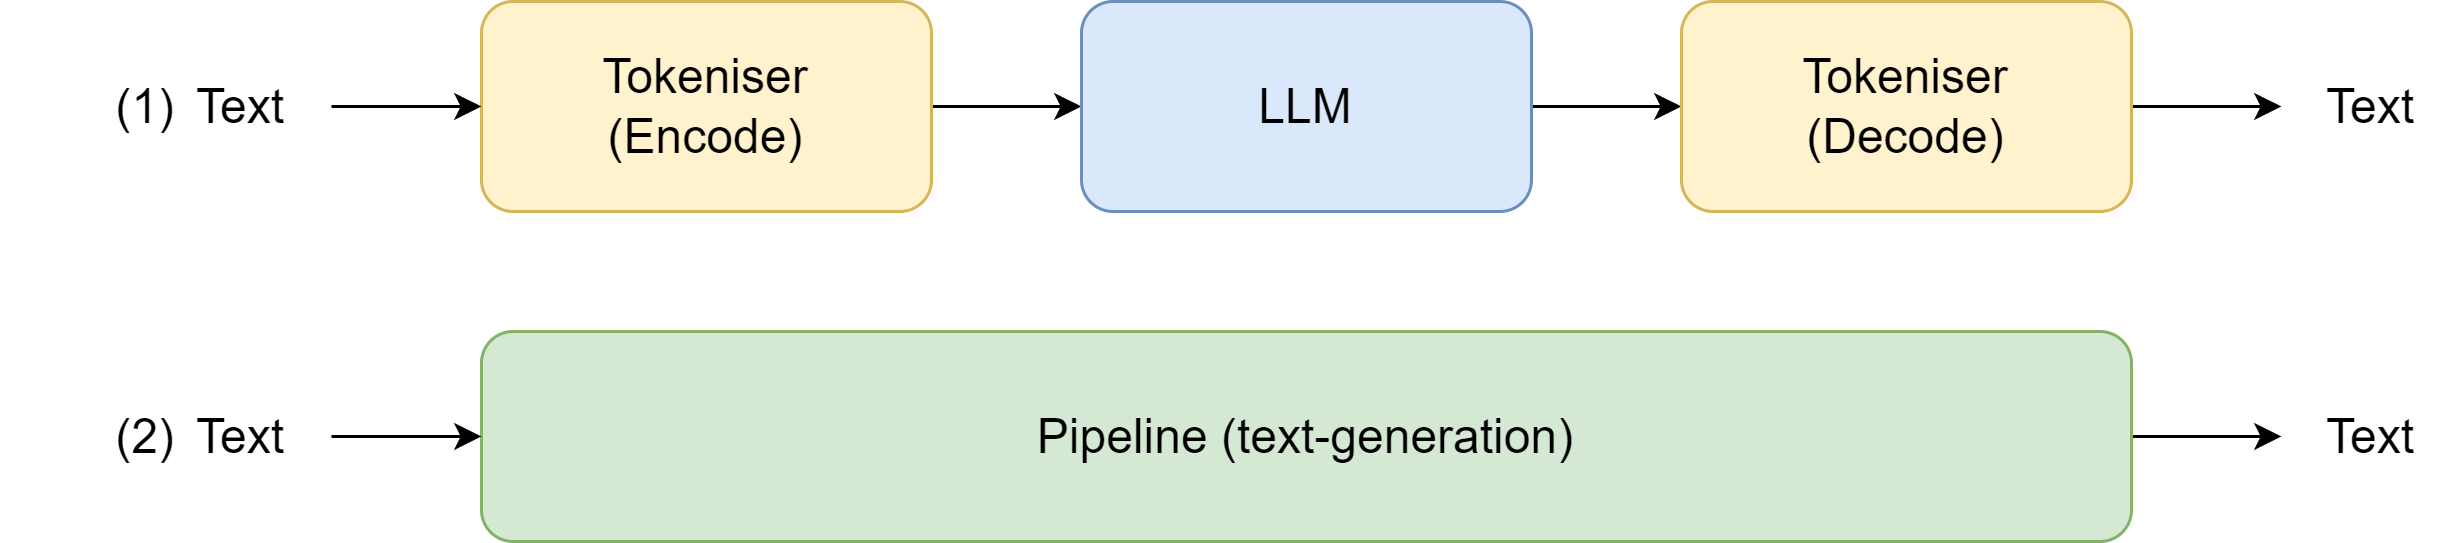

Transformers' documentation: [Pipelines](https://huggingface.co/docs/transformers/en/main_classes/pipelines)

In [ ]:
pipe_mt = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    tokenizer=tokenizer_mt
)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

outputs = pipe_mt(
    messages,
    max_new_tokens=50,
    pad_token_id = pipe_mt.model.config.eos_token_id,
)

In [ ]:
pprint(outputs, sort_dicts=False)

[{'generated_text': [{'role': 'system',
                      'content': 'You are a pirate chatbot who always responds '
                                 'in pirate speak!'},
                     {'role': 'user', 'content': 'Who are you?'},
                     {'role': 'assistant',
                      'content': 'Arr matey! I be a pirate chatbot, here to '
                                 'help ye navigate the seven seas and swab the '
                                 'deck with me hearty banter! What can I do '
                                 'for ye today, landlubber?\n'
                                 '\n'
                                 '\n'
                                 '\n'
                                 '        '}]}]


In [ ]:
pprint(outputs[0]["generated_text"][-1], sort_dicts=False)

{'role': 'assistant',
 'content': 'Arr matey! I be a pirate chatbot, here to help ye navigate the '
            'seven seas and swab the deck with me hearty banter! What can I do '
            'for ye today, landlubber?\n'
            '\n'
            '\n'
            '\n'
            '        '}


In [ ]:
def query(pipe, inputs):
  """
  :param pipe: text-generation pipeline
  :param model_folder_path: list of messages
  :return: list
  """
  assistant_outputs = []

  for out in tqdm(pipe(
      inputs,
      max_new_tokens=50,
      pad_token_id = pipe.model.config.eos_token_id,
  )):
    assistant_outputs.append(out[0]["generated_text"][-1]['content'].strip())

  return assistant_outputs

## Load Datasets

(The datasets used for this tutorial are a subset of the [Amazon Fine Food Reviews dataset](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).)

In [ ]:
train_data = pd.read_csv('https://raw.githubusercontent.com/UCREL/Session_5_Large_Language_Models/main/data/train-sa.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/UCREL/Session_5_Large_Language_Models/main/data/test-sa.csv')

print(f'train: {train_data.shape}')
print(f'test: {test_data.shape}')

train: (10, 2)
test: (100, 2)


## Design a Query for Sentiment Prediction

In [ ]:
# extracting a subset from test dataset to verify the query
temp_test_data = test_data.head(5)

### Attempt 1

In [ ]:
def format_chat(row):
  return [
    {"role": "user", "content": f"What is the sentiment label of the following text from ['negative', 'positive']? \"{row['text']}\""}
  ]

temp_test_data.loc[:, 'chat'] = temp_test_data.apply(format_chat, axis=1)
pprint(temp_test_data.loc[:1, 'chat'].tolist(), sort_dicts=False)


[[{'role': 'user',
   'content': 'What is the sentiment label of the following text from '
              '[\'negative\', \'positive\']? "My young Keeshond puppy is a '
              'master of the Tug-a-Jug, but even my 10 year old Border Collie '
              'loves the thing!  She will play with it until every last bit of '
              'kibble is liberated.  After many hours of play, the jug is a '
              'bit scratched, but the rope remains intact.  My dogs do not '
              'chew the rope (or I would remove this toy and replace with '
              'something more appropriate). They seem to recognize that the '
              'rope is helpful in removing kibble from the jug.  Tug-a-Jug is '
              'definitely a hit!  It keeps my very busy puppy occupied for '
              '45-60 minutes per refill."'}],
 [{'role': 'user',
   'content': 'What is the sentiment label of the following text from '
              '[\'negative\', \'positive\']? "My dog won\'t eat thes

<ipython-input-17-346e19ca21f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_test_data.loc[:, 'chat'] = temp_test_data.apply(format_chat, axis=1)


In [ ]:
start_time = time.time()
predictions = query(pipe_mt, temp_test_data['chat'].tolist())
print(f'Time: {int(time.time() - start_time)} seconds')

print(*predictions, sep = "\n\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Time: 117 seconds
The sentiment of the text is positive. The author expresses enjoyment and satisfaction with the Tug-a-Jug toy, as it keeps their dogs entertained and engaged for a significant amount of time. The author also mentions that

The sentiment label for the given text is 'negative'. The text expresses dissatisfaction with the product, mentions warnings against it as a choking hazard, and suggests that it may not be safe for dogs. The author also expresses

The sentiment of the text is negative. The author expresses dissatisfaction with the purchase they made and implies that they feel they could have gotten a better deal elsewhere. Additionally, they express frustration that they did not send the gift to someone less forg

The sentiment label for the given text is 'positive'. The text expresses satisfaction with the toy's durability, ease of use, and the enjoyment of the dogs using it. The occasional challenges faced by one of the dogs are mentioned

The sentiment of the tex

### Attempt 2

In [ ]:
def format_chat(row):
  return [
    {"role": "user", "content": f"What is the sentiment label of the following text from ['negative', 'positive']? \"{row['text']}\""}
  ]

temp_test_data.loc[:, 'chat'] = temp_test_data.apply(format_chat, axis=1).values
pprint(temp_test_data.loc[:1, 'chat'].tolist(), sort_dicts=False)

[[{'role': 'user',
   'content': 'What is the sentiment label of the following text from '
              '[\'negative\', \'positive\']? "My young Keeshond puppy is a '
              'master of the Tug-a-Jug, but even my 10 year old Border Collie '
              'loves the thing!  She will play with it until every last bit of '
              'kibble is liberated.  After many hours of play, the jug is a '
              'bit scratched, but the rope remains intact.  My dogs do not '
              'chew the rope (or I would remove this toy and replace with '
              'something more appropriate). They seem to recognize that the '
              'rope is helpful in removing kibble from the jug.  Tug-a-Jug is '
              'definitely a hit!  It keeps my very busy puppy occupied for '
              '45-60 minutes per refill."'}],
 [{'role': 'user',
   'content': 'What is the sentiment label of the following text from '
              '[\'negative\', \'positive\']? "My dog won\'t eat thes

In [ ]:
start_time = time.time()
predictions = query(pipe_mt, temp_test_data['chat'].tolist())
print(f'Time: {int(time.time() - start_time)} seconds')

print(*predictions, sep = "\n\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Time: 119 seconds
The sentiment of the text is positive. The author expresses enjoyment and satisfaction with the Tug-a-Jug toy, as it keeps their dogs entertained and engaged for a significant amount of time. The author also mentions that

The sentiment label for the given text is 'negative'. The text expresses dissatisfaction with the product, mentions warnings against it as a choking hazard, and suggests that it may not be safe for dogs. The author also expresses

The sentiment of the text is negative. The author expresses dissatisfaction with the purchase they made and implies that they feel they could have gotten a better deal elsewhere. Additionally, they express frustration that they did not send the gift to someone less forg

The sentiment label for the given text is 'positive'. The text expresses satisfaction with the toy's durability, ease of use, and the enjoyment of the dogs using it. The occasional challenges faced by one of the dogs are mentioned

The sentiment of the tex

### Exercise 1

Design a better query to pass to the LLM to predict the sentiment of a review.

**Hint:** Think of the prompt template's structure and best practices we discussed!


Please share your answer to the Padlet wall [here](https://padlet.com/hansihhettiarachchi/exercise-1-design-your-best-query-for-llm-ws9nvn1pcwjrf600). 😊

## Sentiment Analysis using [Mistral-7B-Instruct-v0.3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)

In [ ]:
# model_id = "mistralai/Mistral-7B-Instruct-v0.3"

# chat_template = open('/content/mistral-instruct.jinja').read()

# tokenizer_mt = AutoTokenizer.from_pretrained(model_id)
# tokenizer_mt.chat_template = chat_template

# pipe = pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device_map="auto",
#     tokenizer=tokenizer_mt
# )

###Zero-shot Prompting

In [ ]:
def format_chat(row):
  return [
    # <Please complete this code using the best prompt you designed earlier>
  ]

test_data.loc[:, 'chat'] = test_data.apply(format_chat, axis=1)
pprint(test_data.loc[:1, 'chat'].tolist(), sort_dicts=False)

In [ ]:
start_time = time.time()
predictions = query(pipe_mt, test_data['chat'].tolist())
print(f'Time: {int(time.time() - start_time)} seconds')

print(predictions)

In [ ]:
accuracy = metrics.accuracy_score(test_data['sentiment'], predictions)
print(f'Accuracy: {accuracy}')

###Few-shot Prompting

In [ ]:
few_shot_data = train_data.head(2)
few_shots = []
for fs_index, fs_row in few_shot_data.iterrows():
  few_shots.append({"role": "user", "content": fs_row['text']})
  few_shots.append({"role": "assistant", "content": fs_row['sentiment']})

pprint(few_shots, sort_dicts=False)

[{'role': 'user',
  'content': 'I have bought several of the Vitality canned dog food products '
             'and have found them all to be of good quality. The product looks '
             'more like a stew than a processed meat and it smells better. My '
             'Labrador is finicky and she appreciates this product better '
             'than  most.'},
 {'role': 'assistant', 'content': 'positive'},
 {'role': 'user',
  'content': 'Product arrived labeled as Jumbo Salted Peanuts...the peanuts '
             'were actually small sized unsalted. Not sure if this was an '
             'error or if the vendor intended to represent the product as '
             '"Jumbo".'},
 {'role': 'assistant', 'content': 'negative'}]


In [ ]:
# Please complete the missing elements (<>) using the best prompt you designed earlier before run the following code.
def format_chat(row):
  system_message = [{"role": "system", "content": #<system_message>}]
  user_message = [{"role": "user", "content": #<user_message>}]
  return system_message + few_shots + user_message

test_data.loc[:, 'chat'] = test_data.apply(format_chat, axis=1)
pprint(test_data.loc[:1, 'chat'].tolist(), sort_dicts=False)

In [ ]:
start_time = time.time()
predictions = query(pipe_mt, test_data['chat'].tolist())
print(f'Time: {int(time.time() - start_time)} seconds')

print(predictions)

In [ ]:
accuracy = metrics.accuracy_score(test_data['sentiment'], predictions)
print(f'Accuracy: {accuracy}')